In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
def generate_data():
    df = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTCUSD_ohlcv.csv'))
    # df = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.iloc[-10000:]
    df.sort_values('datetime', ascending=True, inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df

In [3]:
data = generate_data()
data.head()

,datetime,open,high,low,close,volume
0,2022-12-30 22:05:00,16583.5,16583.5,16583.4,16583.4,4741.0
1,2022-12-30 22:06:00,16583.5,16583.5,16583.5,16583.5,22.0
2,2022-12-30 22:07:00,16583.5,16583.5,16583.4,16583.4,34811.0
3,2022-12-30 22:08:00,16583.5,16583.5,16583.5,16583.5,20.0
4,2022-12-30 22:09:00,16583.5,16583.5,16583.5,16583.5,5783.0


# Indicators

In [4]:
import pandas as pd
import numpy as np
from numba import prange, njit, types
from numba.typed import Dict
import pandas_ta as ta
import itertools
import gc
import time
from scipy.stats import norm, iqr, chi2, chi2_contingency

import warnings
warnings.filterwarnings('ignore')

In [5]:
def normalize_observation(x, x_median, x_iqr, is_centered=True, is_scaled=True):

    if is_centered:
        new_x = x - x_median
    else:
        new_x = x.copy()

    if is_scaled:
        new_x = 100 * norm.cdf(0.25 * new_x / x_iqr) - 50
    else:
        pass

    return new_x

# Creating functions for trend indicators/variables

def MA_DIFFERENCE(df, ShortLength, LongLength, Lag):
    short_ma = ta.sma(df['close'], length=ShortLength)
    long_ma = ta.sma(df['close'].shift(Lag), length=LongLength)
    ma_diff = short_ma - long_ma
    df_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=LongLength+Lag)
    df_stat = ma_diff / df_atr
    period = LongLength+Lag
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['MA_Diff']
    return df_stat

def get_ls_slope(y, length):
    # X = np.vstack([np.arange(1, length+1), np.ones(length, dtype='int')]).T
    # m, c = np.linalg.lstsq(X, y, rcond=None)[0]
    x = np.arange(1, length+1)
    # np.polyfit(x, y, 1)
    return np.polyfit(x, y, 1)[0] #m #* np.arange(1, length+1) + c

def LINEAR_PER_ATR(df, HistLength, ATRlength):
    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))
    df_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ATRlength)
    df_slope = df_log_mean.rolling(window=HistLength).apply(lambda x: get_ls_slope(y=x, length=len(x)))
    df_stat = df_slope / df_atr
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Velocity']
    return df_stat

def get_quad_slope(y, length):
    # X = np.vstack([np.arange(1, length+1), np.ones(length, dtype='int')]).T
    # m, c = np.linalg.lstsq(X, y, rcond=None)[0]
    x = np.arange(1, length+1)
    # np.polyfit(x, y, 1)
    return np.polyfit(x, y, 2)[0] #m #* np.arange(1, length+1) + c

def QUADRATIC_PER_ATR(df, HistLength, ATRlength):
    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))
    df_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ATRlength)
    df_slope = df_log_mean.rolling(window=HistLength).apply(lambda x: get_quad_slope(y=x, length=len(x)))
    df_stat = df_slope / df_atr
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Acceleration']
    return df_stat

def get_cubic_slope(y, length):
    # X = np.vstack([np.arange(1, length+1), np.ones(length, dtype='int')]).T
    # m, c = np.linalg.lstsq(X, y, rcond=None)[0]
    x = np.arange(1, length+1)
    # np.polyfit(x, y, 1)
    return np.polyfit(x, y, 3)[0] #m #* np.arange(1, length+1) + c

def CUBIC_PER_ATR(df, HistLength, ATRlength):
    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))
    df_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ATRlength)
    df_slope = df_log_mean.rolling(window=HistLength).apply(lambda x: get_cubic_slope(y=x, length=len(x)))
    df_stat = df_slope / df_atr
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Acceleration_Rate_of_Change']
    return df_stat

def RSI(df, HistLength):
    rsi_df = ta.rsi(df['close'], length=HistLength).to_frame()
    rsi_df.columns = ['RSI']
    return rsi_df

def STOCHASTIC_K(df, fastk_period, slowk_period, slowd_period):

	df_stat = ta.stoch(
		df["high"], df["low"], df["close"], 
		fastk_period, slowk_period, slowd_period)[f'STOCHk_{fastk_period}_{slowk_period}_{slowd_period}']
	df_stat = df_stat.to_frame()
	df_stat.columns = ['STOCHASTIC_K']
	return df_stat

def STOCHASTIC_D(df, fastk_period, slowk_period, slowd_period):
	df_stat = ta.stoch(
		df["high"], df["low"], df["close"], 
		fastk_period, slowk_period, slowd_period)[f'STOCHd_{fastk_period}_{slowk_period}_{slowd_period}']
	df_stat = df_stat.to_frame()
	df_stat.columns = ['STOCHASTIC_D']
	return df_stat

def PRICE_MOMENTUM(df, HistLength, StdDevLength):

    df_stat = df['close'] / df['close'].shift(HistLength)
    df_std = df['close'].rolling(window=StdDevLength).std()
    df_stat = df_stat / df_std
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Momentum']
    return df_stat

def ADX(df, HistLength):
	df_stat = ta.adx(
		high=df['high'], 
		low=df['low'], 
		close=df['close'], 
		length=HistLength
	)[f'ADX_{HistLength}']

	df_stat = df_stat.to_frame()
	df_stat.columns = ['ADX']
	return df_stat

def MIN_ADX(df, HistLength, MinLength):

    adx_list = []

    for i in range(MinLength):
        temp_adx = ta.adx(
            high=df['high'].shift(i), 
            low=df['low'].shift(i), 
            close=df['close'].shift(i), 
            length=HistLength
        )[f'ADX_{HistLength}']

        adx_list.append(temp_adx.values)

    df_stat = pd.Series(np.min(np.array(adx_list), axis=0), index=temp_adx.index)
    df_stat = df_stat.to_frame()  
    df_stat.columns = ['Min_ADX']
    return df_stat

def RESIDUAL_MIN_ADX(df, HistLength, MinLength):

    current_adx = ta.adx(
        high=df['high'], 
        low=df['low'], 
        close=df['close'], 
        length=HistLength
    )[f'ADX_{HistLength}']

    min_adx = MIN_ADX(df, HistLength, MinLength)

    df_stat = current_adx - min_adx

    return df_stat

def MAX_ADX(df, HistLength, MaxLength):

    adx_list = []

    for i in range(MaxLength):
        temp_adx = ta.adx(
            high=df['high'].shift(i), 
            low=df['low'].shift(i), 
            close=df['close'].shift(i), 
            length=HistLength
        )[f'ADX_{HistLength}']

        adx_list.append(temp_adx.values)

    df_stat = pd.DataFrame(np.max(np.array(adx_list), axis=0), index=df.index)
    df_stat.columns = ['MAX_ADX']
    return df_stat

def RESIDUAL_MAX_ADX(df, HistLength, MaxLength):

    current_adx = ta.adx(
        high=df['high'], 
        low=df['low'], 
        close=df['close'], 
        length=HistLength
    )[f'ADX_{HistLength}']

    max_adx = MAX_ADX(df, HistLength, MaxLength)

    df_stat = max_adx - current_adx

    return df_stat

def DELTA_ADX(df, HistLength,  DeltaLength):

    current_adx = ta.adx(
        high=df['high'], 
        low=df['low'], 
        close=df['close'], 
        length=HistLength
    )[f'ADX_{HistLength}']

    lag_adx = ta.adx(
        high=df['high'].shift(DeltaLength), 
        low=df['low'].shift(DeltaLength), 
        close=df['close'].shift(DeltaLength), 
        length=HistLength
    )[f'ADX_{HistLength}']

    df_stat = current_adx - lag_adx
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['ADX_Velocity']
    return df_stat

def ACCEL_ADX(df, HistLength, DeltaLength):

    current_adx = ta.adx(
        high=df['high'], 
        low=df['low'], 
        close=df['close'], 
        length=HistLength
    )[f'ADX_{HistLength}']

    lag_adx1 = ta.adx(
        high=df['high'].shift(DeltaLength), 
        low=df['low'].shift(DeltaLength), 
        close=df['close'].shift(DeltaLength), 
        length=HistLength
    )[f'ADX_{HistLength}']

    lag_adx2 = ta.adx(
        high=df['high'].shift(2*DeltaLength), 
        low=df['low'].shift(2*DeltaLength), 
        close=df['close'].shift(2*DeltaLength), 
        length=HistLength
    )[f'ADX_{HistLength}']

    df_stat = current_adx + lag_adx2 - 2 * lag_adx1
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['ADX_Acceleration']
    return df_stat

def INTRADAY_INTENSITY(df, HistLength):

    diff1 = df['high'] - df['low']
    diff2 = df['high'] - df['close'].shift(1)
    diff3 = df['close'].shift(1) - df['low']

    true_range = np.max(
        np.array(
            [
                diff1.values, 
                diff2.values, 
                diff3.values
             ]
        ), 
    axis=0
    )

    current_change = df['close'] - df['open']

    df_stat = current_change / true_range
    df_stat = df_stat.rolling(window=HistLength).mean()
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Intraday_Intensity']
    return df_stat

def DELTA_INTRADAY_INTENSITY(df, HistLength, DeltaLength):

    current_inten = INTRADAY_INTENSITY(df, HistLength)
    lag_inten = INTRADAY_INTENSITY(df=df.shift(DeltaLength), HistLength=HistLength)
    df_stat = current_inten - lag_inten
    df_stat.columns = ['Delta_Intraday_Intensity']
    return df_stat

def REACTIVITY(df, HistLength):

    price_change = df['close'] - df['close'].shift(HistLength)

    max_price = df['high'].rolling(window=HistLength).max()
    min_price = df['low'].rolling(window=HistLength).min()
    price_range = max_price - min_price

    total_volume = df['volume'].rolling(window=HistLength).sum()

    ema_price_range = ta.ema(close=price_range, length=8*HistLength)
    ema_total_volume = ta.ema(close=total_volume, length=8*HistLength)
    aspect_ratio = (price_range / ema_price_range) / (total_volume / ema_total_volume)

    raw_reactivity = price_change * aspect_ratio
    df_stat = raw_reactivity / ema_price_range
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Reactivity']
    return df_stat

def DELTA_REACTIVITY(df, HistLength, DeltaDist):

    current_reactivity = REACTIVITY(df, HistLength)
    lag_reactivity = REACTIVITY(df=df.shift(DeltaDist), HistLength=HistLength)

    stat_values = (current_reactivity - lag_reactivity).values.reshape(-1, )

    df_stat = pd.Series(stat_values, index=df.index)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Reactivity']
    return df_stat

def MIN_REACTIVITY(df, HistLength, Dist):

    reactivity_list = []
    for i in range(Dist):
        reactivity_list.append(REACTIVITY(df=df.shift(i), HistLength=HistLength).values)

    stat_values = np.min(np.array(reactivity_list), axis=0).reshape(-1, )

    df_stat = pd.Series(stat_values, index=df.index)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Min_Reactivity']
    return df_stat

def MAX_REACTIVITY(df, HistLength, Dist):

    reactivity_list = []
    for i in range(Dist):
        reactivity_list.append(REACTIVITY(df=df.shift(i), HistLength=HistLength).values)

    stat_values = np.max(np.array(reactivity_list), axis=0).reshape(-1, )

    df_stat = pd.Series(stat_values, index=df.index)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Max_Reactivity']
    return df_stat

# Creating functions for trend like indicators/variables

def CLOSE_TO_CLOSE(df):

    df_stat = 100 * np.log(df['close'] / df['close'].shift(1))
    df_stat = df_stat.to_frame()
    df_stat.columns = ['Close_to_Close']
    return df_stat

@njit
def get_n_day_high(x, y):

    N = len(x) + 1

    for i in prange(len(x)-1, -1, -1):
        if x[i] > y:
            N = i + 1
            break
        else:
            pass

    return 100 * (N-1) / len(x) - 50

@njit
def get_hist_values(x, length):

    hist_values = []

    for i in prange(length, len(x)+1):

        hist_values.append(x[i-length: i])

    return hist_values

def N_DAY_HIGH(df, HistLength):

    list_of_values = get_hist_values(x=df['high'].values, length=HistLength)
    # df['high'].rolling(window=HistLength, closed='left').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['high_list']
    temp_df['high'] = df.iloc[HistLength:]['high']

    df_stat = temp_df.apply(lambda x: get_n_day_high(x=x['high_list'], y=x['high']), axis=1)
    df_stat = df_stat.to_frame()
    df_stat.columns = ['N_Day_High']
    return df_stat

@njit
def get_n_day_low(x, y):

    N = len(x) + 1

    for i in prange(len(x)-1, -1, -1):
        if x[i] < y:
            N = i + 1
            break
        else:
            pass

    return 100 * (N-1) / len(x) - 50

def N_DAY_LOW(df, HistLength):

    list_of_values = get_hist_values(x=df['low'].values, length=HistLength)
    # df['low'].rolling(window=HistLength, closed='left').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['low_list']
    temp_df['low'] = df.iloc[HistLength:]['low']

    df_stat = temp_df.apply(lambda x: get_n_day_low(x=x['low_list'], y=x['low']), axis=1)
    df_stat = df_stat.to_frame()
    df_stat.columns = ['N_Day_Low']
    return df_stat

# Creating functions for indicators/variables of deviations from trend

def CLOSE_MINUS_MOVING_AVERAGE(df, HistLen, ATRlen):

    close_ratio = np.log(df['close'] / df['close'].rolling(window=HistLen).mean())
    atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ATRlen)
    df_stat = close_ratio / atr
    period = HistLen
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['CMMA']
    return df_stat

def get_ls_fit(y):
    length = len(y)
    x = np.arange(1, length+1)
    result = np.polyfit(x, y, 1)
    y_fit = result[1] + length * result[0]
    std_dev = np.sum((y - y_fit)**2)
    std_error = (std_dev / (length-1)) ** 0.5
    return [y_fit, std_error]

def LINEAR_DEVIATION(df, HistLength):

    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))

    list_of_values = get_hist_values(x=df_log_mean.values, length=HistLength)
    # df_log_mean.rolling(window=HistLength, closed='both').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.apply(lambda x: get_ls_fit(y=x))
    temp_df = pd.DataFrame(temp_df.to_list(), columns=['fit','std_error'])
    temp_df.index = df.iloc[HistLength-1:].index
    temp_df['log_price'] = df_log_mean.iloc[HistLength-1:]

    df_stat = (temp_df['log_price'] - temp_df['fit']) / temp_df['std_error']
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Linear_Deviation']
    return df_stat

def get_quadratic_fit(y):
    length = len(y)
    x = np.arange(1, length+1)
    result = np.polyfit(x, y, 2)
    y_fit = result[2] + length * result[1] + (length**2) * result[0]
    std_dev = np.sum((y - y_fit)**2)
    std_error = (std_dev / (length-1)) ** 0.5
    return [y_fit, std_error]

def QUADRATIC_DEVIATION(df, HistLength):

    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))

    # list_of_values = []
    # df_log_mean.rolling(window=HistLength, closed='both').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_values = get_hist_values(x=df_log_mean.values, length=HistLength)

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.apply(lambda x: get_quadratic_fit(y=x))
    temp_df = pd.DataFrame(temp_df.to_list(), columns=['fit','std_error'])
    temp_df.index = df.iloc[HistLength-1:].index
    temp_df['log_price'] = df_log_mean.iloc[HistLength-1:]

    df_stat = (temp_df['log_price'] - temp_df['fit']) / temp_df['std_error']
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Quadratic_Deviation']
    return df_stat

def get_cubic_fit(y):
    length = len(y)
    x = np.arange(1, length+1)
    result = np.polyfit(x, y, 3)
    y_fit = result[3] + length * result[2] + (length**2) * result[1] + (length**3) * result[0]
    std_dev = np.sum((y - y_fit)**2)
    std_error = (std_dev / (length-1)) ** 0.5
    return [y_fit, std_error]

def CUBIC_DEVIATION(df, HistLength):

    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))

    # list_of_values = []
    # df_log_mean.rolling(window=HistLength, closed='both').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_values = get_hist_values(x=df_log_mean.values, length=HistLength)

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.apply(lambda x: get_cubic_fit(y=x))
    temp_df = pd.DataFrame(temp_df.to_list(), columns=['fit','std_error'])
    temp_df.index = df.iloc[HistLength-1:].index
    temp_df['log_price'] = df_log_mean.iloc[HistLength-1:]

    df_stat = (temp_df['log_price'] - temp_df['fit']) / temp_df['std_error']
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Cubic_Deviation']
    return df_stat

def get_ls_fit2(x, y):
    result = np.polyfit(x, y, 1)
    y_fit = result[1] + x[-1] * result[0]
    return y_fit

def DETRENDED_RSI(df, DetrendedLength, DetrenderLength, Lookback):

    rsi_y = ta.rsi(df['close'], length=DetrendedLength)

    if DetrendedLength == 2:
        rsi_y = 1 / (1 + np.exp(-rsi_y))

    rsi_x = ta.rsi(df['close'], length=DetrenderLength)

    rsi_array = np.vstack([rsi_y.values, rsi_x.values]).T
    rsi_df = pd.DataFrame(rsi_array, columns=['rsi_y', 'rsi_x'], index=rsi_y.index)
    rsi_df.dropna(inplace=True)

    # list_of_rsi_y = []
    # rsi_df['rsi_y'].rolling(window=Lookback, closed='both').apply(
    #     lambda x: list_of_rsi_y.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_rsi_y = get_hist_values(x=rsi_df['rsi_y'].values, length=Lookback)

    # list_of_rsi_x = []
    # rsi_df['rsi_x'].rolling(window=Lookback, closed='both').apply(
    #     lambda x: list_of_rsi_x.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_rsi_x = get_hist_values(x=rsi_df['rsi_x'].values, length=Lookback)

    temp_df = pd.Series(list_of_rsi_x, index=df.iloc[Lookback-1+DetrenderLength:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['rsi_x']
    temp_df['rsi_y'] = list_of_rsi_y

    temp_df['fit'] = temp_df.apply(lambda x: get_ls_fit2(x=x['rsi_x'], y=x['rsi_y']), axis=1)
    temp_df['rsi_y'] = rsi_y.iloc[Lookback-1:]

    df_stat = (temp_df['rsi_y'] - temp_df['fit'])
    df_stat = df_stat.to_frame()
    df_stat.columns = ['Detrended_RSI']
    return df_stat

# Creating functions for volatility indicators/variables

def ABS_PRICE_CHANGE_OSCILLATOR(df, ShortLen, Multiplier):

    price_changes = np.abs(np.log(df['close']/df['close'].shift(1)))
    short_ma = price_changes.rolling(window=ShortLen).mean()
    long_ma = price_changes.rolling(window=ShortLen*Multiplier).mean()
    atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ShortLen*Multiplier)
    df_stat = (short_ma - long_ma) / atr
    period = ShortLen
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['APCO']
    return df_stat

def PRICE_VARIANCE_RATIO(df, HistLength, Multiplier):

    log_prices = np.log(df['close'])
    short_var = log_prices.rolling(window=HistLength).var()
    long_var = log_prices.rolling(window=HistLength*Multiplier).var()
    df_stat = short_var / long_var
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['PVR']
    return df_stat

def MIN_PRICE_VARIANCE_RATIO(df, HistLen, Mult, Mlength):

    pvr_list = []

    for i in range(Mlength):

        pvr_list.append(PRICE_VARIANCE_RATIO(df=df.shift(i), HistLength=HistLen, Multiplier=Mult))

    df_stat = np.min(np.array(pvr_list), axis=0)
    df_stat = pd.DataFrame(df_stat, index=df.index)
    df_stat.columns = ['MinPVR']
    return df_stat

def MAX_PRICE_VARIANCE_RATIO(df, HistLen, Mult, Mlength):

    pvr_list = []

    for i in range(Mlength):

        pvr_list.append(PRICE_VARIANCE_RATIO(df=df.shift(i), HistLength=HistLen, Multiplier=Mult))

    df_stat = np.max(np.array(pvr_list), axis=0)
    df_stat = pd.DataFrame(df_stat, index=df.index)
    df_stat.columns = ['MaxPVR']
    return df_stat

def CHANGE_VARIANCE_RATIO(df, HistLength, Multiplier):

    log_prices = np.log(df['close']/df['close'].shift(1))
    short_var = log_prices.rolling(window=HistLength).var()
    long_var = log_prices.rolling(window=HistLength*Multiplier).var()
    df_stat = short_var / long_var
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['CVR']
    return df_stat

def MIN_CHANGE_VARIANCE_RATIO(df, HistLen, Mult, Mlen):

    pvr_list = []

    for i in range(Mlen):

        pvr_list.append(CHANGE_VARIANCE_RATIO(df=df.shift(i), HistLength=HistLen, Multiplier=Mult))

    df_stat = np.min(np.array(pvr_list), axis=0)
    df_stat = pd.DataFrame(df_stat, index=df.index)
    df_stat.columns = ['MinCVR']
    return df_stat

def MAX_CHANGE_VARIANCE_RATIO(df, HistLen, Mult, Mlength):

    pvr_list = []

    for i in range(Mlength):

        pvr_list.append(CHANGE_VARIANCE_RATIO(df=df.shift(i), HistLength=HistLen, Multiplier=Mult))

    df_stat = np.max(np.array(pvr_list), axis=0)
    df_stat = pd.DataFrame(df_stat, index=df.index)
    df_stat.columns = ['MaxCVR']
    return df_stat

def ATR_RATIO(df, HistLength, Multiplier):

    short_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=HistLength)
    long_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=HistLength*Multiplier)
    df_stat = short_atr / long_atr
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['ATR_Ratio']
    return df_stat

def DELTA_PRICE_VARIANCE_RATIO(df, HistLength, Multiplier):

    current_pvr = PRICE_VARIANCE_RATIO(df, HistLength, Multiplier)
    lag_value = HistLength * Multiplier
    lag_pvr = PRICE_VARIANCE_RATIO(df=df.shift(lag_value), HistLength=HistLength, Multiplier=Multiplier)
    df_stat = current_pvr - lag_pvr
    df_stat.columns = ['DPVR']
    return df_stat

def DELTA_CHANGE_VARIANCE_RATIO(df, HistLength, Multiplier):

    current_pvr = CHANGE_VARIANCE_RATIO(df, HistLength, Multiplier)
    lag_value = HistLength * Multiplier
    lag_pvr = CHANGE_VARIANCE_RATIO(df=df.shift(lag_value), HistLength=HistLength, Multiplier=Multiplier)
    df_stat = current_pvr - lag_pvr
    df_stat.columns = ['DCVR']
    return df_stat

def DELTA_ATR_RATIO(df, HistLength, Multiplier):

    current_pvr = ATR_RATIO(df, HistLength, Multiplier)
    lag_value = HistLength * Multiplier
    lag_pvr = ATR_RATIO(df=df.shift(lag_value), HistLength=HistLength, Multiplier=Multiplier)
    df_stat = current_pvr - lag_pvr
    df_stat.columns = ['Delta_ATR_Ration']
    return df_stat

def BOLLINGER_WIDTH(df, HistLength):

    mean = df['close'].rolling(window=HistLength).mean()
    std = df['close'].rolling(window=HistLength).std()
    df_stat = np.log(std / mean)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Bollinger_Width']
    return df_stat

def DELTA_BOLLINGER_WIDTH(df, HistLength, DeltaLength):

    current_bw = BOLLINGER_WIDTH(df, HistLength)
    lag_bw = BOLLINGER_WIDTH(df=df.shift(DeltaLength), HistLength=HistLength)
    df_stat = current_bw - lag_bw
    period = HistLength
    x_median = df_stat.iloc[-period:]['Bollinger_Width'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Bollinger_Width'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Bollinger_Width']
    return df_stat

@njit
def get_n_day_narrower(x, y):

    N = len(x) + 1

    for i in prange(len(x)-1, -1, -1):
        if x[i] < y:
            N = i + 1
            break
        else:
            pass

    return 100 * (N-1) / len(x) - 50

def N_DAY_NARROWER(df, HistLength):

    diff1 = df['high'] - df['low']
    diff2 = df['high'] - df['close'].shift(1)
    diff3 = df['close'].shift(1) - df['low']

    true_range = np.max(
        np.array(
            [
                diff1.values, 
                diff2.values, 
                diff3.values
             ]
        ), 
    axis=0
    )

    true_range = pd.Series(true_range, index=df.index)

    # list_of_values = []
    # true_range.rolling(window=HistLength, closed='left').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_values = get_hist_values(x=true_range.values, length=HistLength)

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['tr_list']
    temp_df['tr'] = true_range.iloc[HistLength+1:]

    df_stat = temp_df.apply(lambda x: get_n_day_narrower(x=x['tr_list'], y=x['tr']), axis=1)
    df_stat = df_stat.to_frame()
    df_stat.columns = ['N_Day_Narrower']
    return df_stat

@njit
def get_n_day_wider(x, y):

    N = len(x) + 1

    for i in prange(len(x)-1, -1, -1):
        if x[i] > y:
            N = i + 1
            break
        else:
            pass

    return 100 * (N-1) / len(x) - 50

def N_DAY_WIDER(df, HistLength):

    diff1 = df['high'] - df['low']
    diff2 = df['high'] - df['close'].shift(1)
    diff3 = df['close'].shift(1) - df['low']

    true_range = np.max(
        np.array(
            [
                diff1.values, 
                diff2.values, 
                diff3.values
             ]
        ), 
    axis=0
    )

    true_range = pd.Series(true_range, index=df.index)

    # list_of_values = []
    # true_range.rolling(window=HistLength, closed='left').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_values = get_hist_values(x=true_range.values, length=HistLength)

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['tr_list']
    temp_df['tr'] = true_range.iloc[HistLength+1:]

    df_stat = temp_df.apply(lambda x: get_n_day_wider(x=x['tr_list'], y=x['tr']), axis=1)
    df_stat = df_stat.to_frame()
    df_stat.columns = ['N_Day_Wider']
    return df_stat

# Creating functions for basic price distribution statistics

def PRICE_SKEWNESS(df, HistLength, Multiplier):

    short_skew = df['close'].rolling(window=HistLength).skew()

    if Multiplier > 1:
        long_skew = df['close'].rolling(window=HistLength*Multiplier).skew()
        df_stat = short_skew / long_skew
    else:
        df_stat = short_skew

    df_stat = df_stat.to_frame()
    df_stat.columns = ['Price_Skewness']
    return df_stat

def CHANGE_SKEWNESS(df, HistLength, Multiplier):

    price_change = df['close'] / df['close'].shift(1)

    short_skew = price_change.rolling(window=HistLength).skew()

    if Multiplier > 1:
        long_skew = price_change.rolling(window=HistLength*Multiplier).skew()
        df_stat = short_skew / long_skew
    else:
        df_stat = short_skew

    df_stat = df_stat.to_frame()
    df_stat.columns = ['Change_Skewness']
    return df_stat

def PRICE_KURTOSIS(df, HistLength, Multiplier):

    short_kurtosis = df['close'].rolling(window=HistLength).kurt()

    if Multiplier > 1:
        long_kurtosis = df['close'].rolling(window=HistLength*Multiplier).kurt()
        df_stat = short_kurtosis / long_kurtosis
    else:
        df_stat = short_kurtosis

    df_stat = df_stat.to_frame()
    df_stat.columns = ['Price_Kurtosis']
    return df_stat

def CHANGE_KURTOSIS(df, HistLength, Multiplier):

    price_change = df['close'] / df['close'].shift(1)

    short_kurtosis = price_change.rolling(window=HistLength).kurt()

    if Multiplier > 1:
        long_kurtosis = price_change.rolling(window=HistLength*Multiplier).kurt()
        df_stat = short_kurtosis / long_kurtosis
    else:
        df_stat = short_kurtosis

    df_stat = df_stat.to_frame()
    df_stat.columns = ['Change_Kurtosis']
    return df_stat

def DELTA_PRICE_SKEWNESS(df, HistLen, Multiplier, DeltaLen):

    current_ps = PRICE_SKEWNESS(df, HistLen, Multiplier)
    lag_ps = PRICE_SKEWNESS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_ps - lag_ps
    df_stat.columns = ['Delta_Price_Skewness']
    return df_stat

def DELTA_CHANGE_SKEWNESS(df, HistLen, Multiplier, DeltaLen):

    current_cs = CHANGE_SKEWNESS(df, HistLen, Multiplier)
    lag_cs = CHANGE_SKEWNESS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_cs - lag_cs
    df_stat.columns = ['Delta_Change_Skewness']
    return df_stat

def DELTA_PRICE_KURTOSIS(df, HistLen, Multiplier, DeltaLen):

    current_pk = PRICE_KURTOSIS(df, HistLen, Multiplier)
    lag_pk = PRICE_KURTOSIS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_pk - lag_pk
    df_stat.columns = ['Delta_Price_Kurtosis']
    return df_stat

def DELTA_CHANGE_KURTOSIS(df, HistLen, Multiplier, DeltaLen):

    current_ck = CHANGE_KURTOSIS(df, HistLen, Multiplier)
    lag_ck = CHANGE_KURTOSIS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_ck - lag_ck
    df_stat.columns = ['Delta_Change_Kurtosis']
    return df_stat

# Creating functions for indicators/variables that significantly involve volume

def VOLUME_MOMENTUM(df, HistLength, Multiplier):

    short_ma = df['volume'].rolling(window=HistLength).mean()
    long_ma = df['volume'].rolling(window=HistLength*Multiplier).mean()
    df_stat = short_ma / long_ma
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Volume_Momentum']
    return df_stat

def DELTA_VOLUME_MOMENTUM(df, HistLen, Multiplier, DeltaLen):

    current_vm = CHANGE_KURTOSIS(df, HistLen, Multiplier)
    lag_vm = CHANGE_KURTOSIS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_vm - lag_vm
    period = HistLen
    x_median = df_stat.iloc[-period:]['Change_Kurtosis'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Change_Kurtosis'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Volume_Momentum']
    return df_stat

def VOLUME_WEIGHTED_MA_OVER_MA(df, HistLength):

    volume_sum = df['volume'].rolling(window=HistLength).sum()
    vp = df['close'] * df['volume']
    vp_sum = vp.rolling(window=HistLength).sum()
    ma_vw = vp_sum / volume_sum

    simple_ma = df['close'].rolling(window=HistLength).mean()

    df_stat = np.log(ma_vw / simple_ma)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['VWMOM']
    return df_stat

def DIFF_VOLUME_WEIGHTED_MA_OVER_MA(df, ShortDist, LongDist):

    short_vwmom = VOLUME_WEIGHTED_MA_OVER_MA(df, HistLength=ShortDist)
    long_vwmom = VOLUME_WEIGHTED_MA_OVER_MA(df, HistLength=LongDist)
    df_stat = short_vwmom - long_vwmom
    period = ShortDist
    x_median = df_stat.iloc[-period:]['VWMOM'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['VWMOM'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Diff_VWMOM']
    return df_stat

def get_ls_slope2(x, y):
    result = np.polyfit(x, y, 1)
    return result[0]

@njit
def get_hist_values(x, length):

    hist_values = []

    for i in prange(length, len(x)+1):

        hist_values.append(x[i-length: i])

    return hist_values

def PRICE_VOLUME_FIT(df, HistLength):

    log_price = np.log(df['close'])

    log_volume = np.log(df['volume']).replace(-np.inf, 0)

    log_array = np.vstack([log_price.values, log_volume.values]).T
    log_df = pd.DataFrame(log_array, columns=['log_price', 'log_volume'], index=log_price.index)
    log_df.dropna(inplace=True)

    list_of_log_price = get_hist_values(x=log_df['log_price'].values, length=HistLength)

    list_of_log_volume = get_hist_values(x=log_df['log_volume'].values, length=HistLength)

    index_length = len(list_of_log_volume)
    temp_df = pd.Series(list_of_log_volume, index=df.iloc[-index_length:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['log_volume']
    temp_df['log_price'] = list_of_log_price

    temp_df['slope'] = temp_df.apply(lambda x: get_ls_slope2(x=x['log_volume'], y=x['log_price']), axis=1)

    df_stat = temp_df['slope']
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Volume_Fit']
    return df_stat

def DIFF_PRICE_VOLUME_FIT(df, ShortDist, LongDist):

    short_pvf = PRICE_VOLUME_FIT(df, HistLength=ShortDist)
    long_pvf = PRICE_VOLUME_FIT(df, HistLength=LongDist)
    df_stat = short_pvf - long_pvf
    period = ShortDist
    x_median = df_stat.iloc[-period:]['Price_Volume_Fit'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Price_Volume_Fit'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Diff_PVF']
    return df_stat

def DELTA_PRICE_VOLUME_FIT(df, HistLength, DeltaDist):

    current_pvf = PRICE_VOLUME_FIT(df, HistLength)
    lag_pvf = PRICE_VOLUME_FIT(df=df.shift(DeltaDist), HistLength=HistLength)
    df_stat = current_pvf - lag_pvf
    period = HistLength
    x_median = df_stat.iloc[-period:]['Price_Volume_Fit'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Price_Volume_Fit'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_PVF']
    return df_stat

def ON_BALANCE_VOLUME(df, HistLength):

    bool1 = (df['close'] > df['close'].shift(1)).astype(int)
    volume1 = df['volume'] * bool1
    signed_volume1 = volume1.rolling(window=HistLength).sum()

    bool2 = (df['close'] < df['close'].shift(1)).astype(int)
    volume2 = df['volume'] * bool2
    signed_volume2 = volume2.rolling(window=HistLength).sum()

    signed_volume = signed_volume1 - signed_volume2

    total_volume = df['volume'].rolling(window=HistLength).sum()

    df_stat = signed_volume / total_volume
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['On_Balance_Volume']
    return df_stat

def DELTA_ON_BALANCE_VOLUME(df, HistLength, DeltaDist):

    current_obv = ON_BALANCE_VOLUME(df, HistLength)
    lag_obv = ON_BALANCE_VOLUME(df=df.shift(DeltaDist), HistLength=HistLength)
    df_stat = current_obv - lag_obv
    period = HistLength
    x_median = df_stat.iloc[-period:]['On_Balance_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['On_Balance_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_OBV']
    return df_stat

def POSITIVE_VOLUME_INDICATOR(df, HistLength):

    price_change = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
    is_increased = (df['volume'] > df['volume'].shift(1))
    price_change = price_change * is_increased
    df_stat = price_change.rolling(window=HistLength).mean()

    std_length = np.max([2*HistLength, 250])
    std_price_change = price_change.rolling(window=std_length).std()
    df_stat = df_stat / std_price_change

    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Positive_Volume']
    return df_stat

def DELTA_POSITIVE_VOLUME_INDICATOR(df, HistLength, DeltaDist):

    current_pv = POSITIVE_VOLUME_INDICATOR(df, HistLength)
    lag_pv = POSITIVE_VOLUME_INDICATOR(df=df.shift(DeltaDist), HistLength=HistLength)
    df_stat = current_pv - lag_pv
    period = HistLength
    x_median = df_stat.iloc[-period:]['Positive_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Positive_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Positive_Volume']
    return df_stat

def NEGATIVE_VOLUME_INDICATOR(df, HistLength):

    price_change = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
    is_decreased = (df['volume'] < df['volume'].shift(1))
    price_change = price_change * is_decreased
    df_stat = price_change.rolling(window=HistLength).mean()

    std_length = np.max([2*HistLength, 250])
    std_price_change = price_change.rolling(window=std_length).std()
    df_stat = df_stat / std_price_change

    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Negative_Volume']
    return df_stat

def DELTA_NEGATIVE_VOLUME_INDICATOR(df, HistLength, DeltaDist):

    current_pv = NEGATIVE_VOLUME_INDICATOR(df, HistLength)
    lag_pv = NEGATIVE_VOLUME_INDICATOR(df=df.shift(DeltaDist), HistLength=HistLength)
    df_stat = current_pv - lag_pv
    period = HistLength
    x_median = df_stat.iloc[-period:]['Negative_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Negative_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Negative_Volume']
    return df_stat

def PRODUCT_PRICE_VOLUME(df, HistLength):

    median_volume = df['volume'].rolling(window=250).median()
    normalized_volume = df['volume'] / median_volume

    price_changes = np.log(df['close']/df['close'].shift(1))
    median_price_changes = price_changes.rolling(window=250).median()
    quantile25 = price_changes.rolling(window=250).quantile(0.25)
    quantile75 = price_changes.rolling(window=250).quantile(0.75)
    iqr_price_changes = quantile75 - quantile25
    normalized_price_changes = (price_changes - median_price_changes) / iqr_price_changes

    precursor = normalized_volume * normalized_price_changes

    df_stat = precursor.rolling(window=HistLength).mean()
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Product_Price_Volume']
    return df_stat

def SUM_PRICE_VOLUME(df, HistLength):

    median_volume = df['volume'].rolling(window=250).median()
    normalized_volume = df['volume'] / median_volume

    price_changes = np.log(df['close']/df['close'].shift(1))
    median_price_changes = price_changes.rolling(window=250).median()
    quantile25 = price_changes.rolling(window=250).quantile(0.25)
    quantile75 = price_changes.rolling(window=250).quantile(0.75)
    iqr_price_changes = quantile75 - quantile25
    normalized_price_changes = (price_changes - median_price_changes) / iqr_price_changes

    sum_sign = np.array(list(map(lambda x: -1 if x<0 else 1, normalized_price_changes)))
    precursor = (normalized_volume + np.abs(normalized_price_changes)) * sum_sign

    df_stat = precursor.rolling(window=HistLength).mean()
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Sum_Price_Volume']
    return df_stat

def DELTA_PRODUCT_PRICE_VOLUME(df, HistLen, DeltaDist):

    current_ppv = PRODUCT_PRICE_VOLUME(df, HistLen)
    lag_ppv = PRODUCT_PRICE_VOLUME(df=df.shift(DeltaDist), HistLength=HistLen)
    df_stat = current_ppv - lag_ppv
    period = HistLen
    x_median = df_stat.iloc[-period:]['Product_Price_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Product_Price_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_PPV']
    return df_stat

def DELTA_SUM_PRICE_VOLUME(df, HistLen, DeltaDist):

    current_ppv = SUM_PRICE_VOLUME(df, HistLen)
    lag_ppv = SUM_PRICE_VOLUME(df=df.shift(DeltaDist), HistLength=HistLen)
    df_stat = current_ppv - lag_ppv
    period = HistLen
    x_median = df_stat.iloc[-period:]['Sum_Price_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Sum_Price_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_SPV']
    return df_stat

# Creating functions for entropy and mutual information indicators/variables

@njit
def get_entropy(x):

    entropy = 0

    for i in prange(len(x)):
        p = x[i] / np.sum(x)
        entropy += -p * np.log2(p)

    return entropy

def PRICE_ENTROPY(df, WordLength):

    length = 10 * (2 ** WordLength)

    bool_list = []

    for i in range(length):
        price_bool1 = ((df['close'].shift(i) > df['close'].shift(i+1)).astype(int)).astype(str)
        price_bool2 = ((df['close'].shift(i+1) > df['close'].shift(i+2)).astype(int)).astype(str)
        price_bool = price_bool1 + price_bool2

        bool_list.append(price_bool.values)

        del price_bool1, price_bool2, price_bool
        gc.collect()

    bool_list = np.array(bool_list).T.tolist()

    temp_df = pd.Series(bool_list, index=df.index).apply(lambda x: np.unique(x, return_counts=True)[1])
    df_stat = temp_df.apply(get_entropy)
    period = length
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Entropy']
    return df_stat

def VOLUME_ENTROPY(df, WordLength):

    length = 10 * (2 ** WordLength)

    bool_list = []

    for i in range(length):
        volume_bool1 = ((df['volume'].shift(i) > df['volume'].shift(i+1)).astype(int)).astype(str)
        volume_bool2 = ((df['volume'].shift(i+1) > df['volume'].shift(i+2)).astype(int)).astype(str)
        volume_bool = volume_bool1 + volume_bool2

        bool_list.append(volume_bool.values)

        del volume_bool1, volume_bool2, volume_bool
        gc.collect()  

    bool_list = np.array(bool_list).T.tolist()

    temp_df = pd.Series(bool_list, index=df.index).apply(lambda x: np.unique(x, return_counts=True)[1])
    df_stat = temp_df.apply(get_entropy)
    period = length
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Volume_Entropy']
    return df_stat

@njit
def get_mi_data(x, length):
    
    xc = []
    x1 = []
    x2 = []
    x3 = []

    for i in prange(length, len(x)):

        xc.append(x[i-length:i])
        x1.append(x[i-length:i-1])
        x2.append(x[i-length:i-2])
        x3.append(x[i-length:i-3])

    return xc, x1, x2, x3

@njit
def get_mi(c, x, y, z):

    bool1 = np.where(c[1:] > x, 1, 0)
    bool2 = np.where(x[1:] > y, 1, 0)
    bool3 = np.where(y[1:] > z, 1, 0)

    var23 = np.zeros(len(bool3), dtype='int')
    var123 = np.zeros(len(bool3), dtype='int')

    for i in prange(len(bool3)):

        if bool2[i+1] == 0 and bool3[i] == 0:

            var23[i] = 1

            if bool1[i+3] == 0:
                var123[i] = 1
            else:
                var123[i] = 2

        elif bool2[i+1] == 1 and bool3[i] == 0:

            var23[i] = 2

            if bool1[i+3] == 0:
                var123[i] = 3
            else:
                var123[i] = 4

        elif bool2[i+1] == 0 and bool3[i] == 1:

            var23[i] = 3

            if bool1[i+3] == 0:
                var123[i] = 5
            else:
                var123[i] = 6

        else:

            var23[i] = 4

            if bool1[i+3] == 0:
                var123[i] = 7
            else:
                var123[i] = 8
    
    prob1 = np.zeros(2)
    for i in prange(2):
        prob1[i] = np.sum(np.where(bool1==i, 1, 0))/ len(bool1)

    prob23 = np.zeros(4)
    for i in prange(1, 5):
        prob23[i] = np.sum(np.where(var23==i, 1, 0))/ len(var23)

    prob123 = np.zeros(8)
    for i in prange(1, 9):
        prob123[i] = np.sum(np.where(var123==i, 1, 0))/ len(var123)


    mi = 0

    for i in prange(2):
        for j in prange(2):
            for k in prange(2):
                
                if j == 0 and k == 0:

                    py = prob23[0]

                    if i == 0:
                        pxy = prob123[0]
                        px = prob1[0]
                    else:
                        pxy = prob123[1]
                        px = prob1[1]

                elif j == 1 and k == 0:

                    py = prob23[1]

                    if i == 0:
                        pxy = prob123[2]
                        px = prob1[0]
                    else:
                        pxy = prob123[3]
                        px = prob1[1]

                elif j == 0 and k == 1:

                    py = prob23[2]

                    if i == 0:
                        pxy = prob123[4]
                        px = prob1[0]
                    else:
                        pxy = prob123[5]
                        px = prob1[1]

                else:

                    py = prob23[3]

                    if i == 0:
                        pxy = prob123[6]
                        px = prob1[0]
                    else:
                        pxy = prob123[7]
                        px = prob1[1]

                if px * py == 0:
                    mi += 0
                else:
                    mi += pxy * np.log(pxy/(px*py))

    return mi

def PRICE_MUTUAL_INFORMATION(df, WordLength):

    length = 10 * (2 ** (1 + WordLength))

    xc, x1, x2, x3 = get_mi_data(x=df['close'].values, length=length)
    temp_df = pd.Series(xc, index=df.index[length:])
    temp_df = temp_df.to_frame()
    temp_df.columns = ['price']
    temp_df['price_lag1'] = x1
    temp_df['price_lag2'] = x2
    temp_df['price_lag3'] = x3
    df_stat = temp_df.apply(
        lambda x: get_mi(
            c=x['price'], 
            x=x['price_lag1'], 
            y=x['price_lag2'], 
            z=x['price_lag3']
        ), 
        axis=1
    )

    period = length
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_MI']
    return df_stat

def VOLUME_MUTUAL_INFORMATION(df, WordLength):

    length = 10 * (2 ** (1 + WordLength))

    xc, x1, x2, x3 = get_mi_data(x=df['volume'].values, length=length)
    temp_df = pd.Series(xc, index=df.index[length:])
    temp_df = temp_df.to_frame()
    temp_df.columns = ['volume']
    temp_df['volume_lag1'] = x1
    temp_df['volume_lag2'] = x2
    temp_df['volume_lag3'] = x3
    df_stat = temp_df.apply(
        lambda x: get_mi(
            c=x['volume'], 
            x=x['volume_lag1'], 
            y=x['volume_lag2'], 
            z=x['volume_lag3']
        ), 
        axis=1
    )

    period = length
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Volume_MI']
    return df_stat

# Grammar

In [23]:
from numba import njit

@njit
def merge_pnl(arr1, arr2):
    out = np.zeros((len(arr1) + len(arr2)))
    idx = 1
    for i in range(len(arr1) + len(arr2)):
        if i % 2 == 0:
            out[i] = arr1[int(i/2)]
        else:
            out[i] = arr2[i-idx]
        idx += 1
    return out

@njit
def get_drawdowns(arr):
    drawdowns = np.zeros((len(arr)))
    max = arr[0]
    for i in range(1, len(drawdowns)-1):
        if arr[i-1] > arr[i] and arr[i] < arr[i+1]:
            min = arr[i]
            drawdowns[i] = max - min
        elif arr[i-1] < arr[i] and arr[i] > arr[i+1]:
            max = arr[i]
    return drawdowns

In [52]:
df = data.copy()

In [53]:
# df['buy'] = (MA_DIFFERENCE(df=data, ShortLength=9, LongLength=7, Lag=478).values <= df['open'].values.reshape(-1, 1)).astype(int)
# df['sell'] = (RSI(df=data, HistLength=9).values + df['high'].values.reshape(-1, 1) >= 0.5).astype(int)
# df['signal'] = df['buy'] + df['sell']
# df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
# df['sell'] = df['sell'] * (-1)
# df['signal'] = df['signal'] * df['sell']
# df['signal'] = df['signal'] + df['buy']
# df.drop(columns=['buy', 'sell'], inplace=True)

# df = df.assign(buy=(df.open.values.reshape(-1, 1) >= df.volume.values.reshape(-1, 1)).astype(int))
# df = df.assign(sell=(df.volume.values.reshape(-1, 1) * df.close.values.reshape(-1, 1) <= 8.3).astype(int))
# df = df.assign(signal = (df.buy + df.sell).values)
# df.signal = df.signal.apply(lambda x: 1 if x==1 else 0)
# df.sell = df.sell * (-1)
# df.signal = df.signal * df.sell
# df.signal = df.signal + df.buy
# df.drop(columns=['buy', 'sell'], inplace=True)

df['buy'] = (9.2 <= df['open'].values.reshape(-1, 1)).astype(int)
df['sell'] = (df['high'].values.reshape(-1, 1) // df['open'].values.reshape(-1, 1) >= 9.833).astype(int)
df['signal'] = df['buy'] + df['sell']
df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
df['sell'] = df['sell'] * (-1)
df['signal'] = df['signal'] * df['sell']
df['signal'] = df['signal'] + df['buy']
df.drop(columns=['buy', 'sell'], inplace=True)

In [54]:
buy_idxs = []
sell_idxs = []
is_buy = 0
is_sell = 0
for i, row in enumerate(df.itertuples()):
    if row.signal == 1 and is_buy == 0:
        buy_idxs.append(i+1)
        is_buy = 1
        is_sell = 0
    elif row.signal == -1 and is_sell == 0:
        sell_idxs.append(i+1)
        is_sell = 1
        is_buy = 0
if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    fitness = -999
buy_prices = df[df.index.isin(buy_idxs)].open.values
sell_prices = df[df.index.isin(sell_idxs)].open.values
if buy_idxs[0] < sell_idxs[0]:
    buy_pnl = np.sum(sell_prices - buy_prices)
    sell_pnl = np.sum(sell_prices[:-1] - buy_prices[1:])
else:
    sell_pnl = np.sum(sell_prices - buy_prices)
    buy_pnl = np.sum(sell_prices[1:] - buy_prices[:-1])
total_pnl = buy_pnl + sell_pnl
if buy_idxs[0] < sell_idxs[0]:
    buy_arr = sell_prices - buy_prices
    sell_arr = sell_prices[:-1] - buy_prices[1:]
    all_arr = merge_pnl(buy_arr, sell_arr)
else:
    sell_arr = sell_prices - buy_prices
    buy_arr = sell_prices[1:] - buy_prices[:-1]
    all_arr = merge_pnl(sell_arr, buy_arr)
equity_curve_arr = np.cumsum(all_arr)
drawdowns = get_drawdowns(equity_curve_arr)
avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
fitness = total_pnl / avg_drawdown

IndexError: list index out of range

In [49]:
all_arr

array([44.6])

In [32]:
fitness

nan

In [55]:
buy_idxs

[1]

In [56]:
sell_idxs

[]

In [35]:
total_pnl

44.60000000000218

In [60]:
fitness

-999

In [59]:
np.isnan(fitness)

False

In [15]:
df.head()

,datetime,open,high,low,close,volume,buy,sell
0,2022-12-30 22:05:00,16583.5,16583.5,16583.4,16583.4,4741.0,0,0
1,2022-12-30 22:06:00,16583.5,16583.5,16583.5,16583.5,22.0,0,0
2,2022-12-30 22:07:00,16583.5,16583.5,16583.4,16583.4,34811.0,0,0
3,2022-12-30 22:08:00,16583.5,16583.5,16583.5,16583.5,20.0,0,0
4,2022-12-30 22:09:00,16583.5,16583.5,16583.5,16583.5,5783.0,0,0


In [16]:
df['buy'].sum(), df['sell'].sum()

(0, 0)

In [43]:
equity_curve_arr

array([44.6])

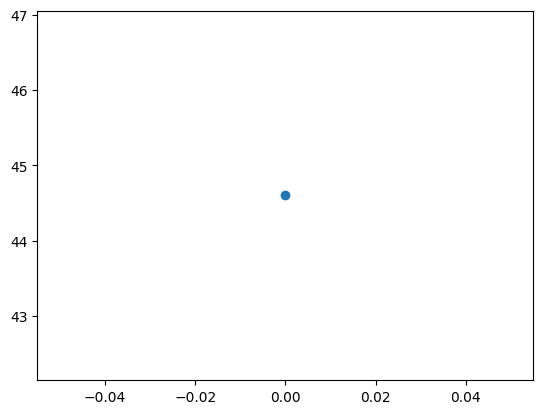

In [44]:
import matplotlib.pyplot as plt

plt.scatter(np.arange(len(equity_curve_arr)), equity_curve_arr)
for i in range(len(drawdowns)):
    if drawdowns[i] != 0:
        plt.plot(i, equity_curve_arr[i] - 10, marker='^', color='orange')
plt.show()

In [58]:
17547.4 / (60 * 60)

4.874277777777778

# BTC and ETH merging

In [100]:
df_btc = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTC-1m.csv'))
# df_btc = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
df_btc['datetime'] = pd.to_datetime(df_btc['datetime'])
df_btc = df_btc.iloc[-10000:]
df_btc.sort_values('datetime', ascending=True, inplace=True)
df_btc.reset_index(inplace=True, drop=True)
df_btc.rename(
    columns={
        'open': 'btc_open', 
        'close': 'btc_close', 
        'low': 'btc_low', 
        'high': 'btc_high', 
        'volume': 'btc_volume'
    },
    inplace=True
)
df_btc.head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume
0,2024-09-04 17:50:00,58052.27,58055.91,57961.70,57975.48,6.286958
1,2024-09-04 17:51:00,57975.48,58014.30,57945.01,57948.03,13.541664
2,2024-09-04 17:52:00,57948.03,57948.03,57888.06,57892.97,11.412409
3,2024-09-04 17:53:00,57889.36,57898.18,57836.55,57857.49,6.163645
4,2024-09-04 17:54:00,57857.51,57915.60,57857.51,57912.29,8.040556


In [101]:
df_btc.tail()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume
9995,2024-09-11 16:25:00,56864.38,56923.75,56847.32,56903.83,12.777984
9996,2024-09-11 16:26:00,56904.37,56916.37,56788.22,56808.40,10.192957
9997,2024-09-11 16:27:00,56804.54,56821.79,56787.89,56798.19,2.912109
9998,2024-09-11 16:28:00,56798.19,56831.83,56793.29,56830.72,3.706732
9999,2024-09-11 16:29:00,56828.08,56864.97,56828.08,56848.40,3.865301


In [102]:
df_eth = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\ETH-1m.csv'))
# df_eth = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
df_eth['datetime'] = pd.to_datetime(df_eth['datetime'])
df_eth = df_eth.iloc[-10000:]
df_eth.sort_values('datetime', ascending=True, inplace=True)
df_eth.reset_index(inplace=True, drop=True)
df_eth.rename(
    columns={
        'open': 'eth_open', 
        'close': 'eth_close', 
        'low': 'eth_low', 
        'high': 'eth_high', 
        'volume': 'eth_volume'
    },
    inplace=True
)
df_eth.head()

,datetime,eth_open,eth_high,eth_low,eth_close,eth_volume
0,2024-09-07 14:22:00,2295.48,2295.48,2292.22,2292.22,8.133025
1,2024-09-07 14:23:00,2292.23,2293.17,2291.09,2292.84,18.279947
2,2024-09-07 14:24:00,2292.75,2293.33,2291.55,2292.98,12.682892
3,2024-09-07 14:25:00,2292.98,2293.07,2291.24,2292.00,29.546565
4,2024-09-07 14:26:00,2291.81,2294.84,2291.80,2294.80,7.415414


In [103]:
df_eth.tail()

,datetime,eth_open,eth_high,eth_low,eth_close,eth_volume
9995,2024-09-14 12:57:00,2421.30,2421.45,2420.28,2421.45,37.802834
9996,2024-09-14 12:58:00,2421.39,2421.44,2421.02,2421.24,3.580702
9997,2024-09-14 12:59:00,2421.24,2421.70,2421.12,2421.44,15.611558
9998,2024-09-14 13:00:00,2421.46,2421.52,2420.57,2421.40,10.753724
9999,2024-09-14 13:01:00,2421.26,2421.29,2420.61,2420.61,4.673591


In [104]:
df_sol = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\SOL-1m.csv'))
# df_sol = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
df_sol['datetime'] = pd.to_datetime(df_sol['datetime'])
df_sol = df_sol.iloc[-10000:]
df_sol.sort_values('datetime', ascending=True, inplace=True)
df_sol.reset_index(inplace=True, drop=True)
df_sol.rename(
    columns={
        'open': 'sol_open', 
        'close': 'sol_close', 
        'low': 'sol_low', 
        'high': 'sol_high', 
        'volume': 'sol_volume'
    },
    inplace=True
)
df_sol.head()

,datetime,sol_open,sol_high,sol_low,sol_close,sol_volume
0,2023-11-22 12:01:00,54.50,54.52,54.47,54.51,475.244
1,2023-11-22 12:02:00,54.52,54.52,54.49,54.52,371.520
2,2023-11-22 12:03:00,54.50,54.63,54.50,54.63,538.134
3,2023-11-22 12:04:00,54.63,54.72,54.54,54.72,87.496
4,2023-11-22 12:05:00,54.72,54.72,54.70,54.70,4112.125


In [105]:
df_sol.tail()

,datetime,sol_open,sol_high,sol_low,sol_close,sol_volume
9995,2023-11-29 10:40:00,60.21,60.31,60.04,60.31,2471.730
9996,2023-11-29 10:41:00,60.32,60.32,60.22,60.26,417.767
9997,2023-11-29 10:42:00,60.28,60.30,60.22,60.30,541.638
9998,2023-11-29 10:43:00,60.32,60.45,60.29,60.33,1013.428
9999,2023-11-29 10:44:00,60.26,60.31,60.16,60.19,1979.268


In [106]:
# df_btc.set_index('datetime', inplace=True)
# df_eth.set_index('datetime', inplace=True)

df_m = pd.merge(df_btc, df_eth, on='datetime')
df_m.sort_values('datetime', ascending=True)
df_m.head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume,eth_open,eth_high,eth_low,eth_close,eth_volume
0,2024-09-07 14:22:00,54626.71,54626.71,54575.54,54587.68,3.029570,2295.48,2295.48,2292.22,2292.22,8.133025
1,2024-09-07 14:23:00,54579.67,54596.70,54557.25,54588.69,4.557107,2292.23,2293.17,2291.09,2292.84,18.279947
2,2024-09-07 14:24:00,54585.02,54605.49,54568.01,54605.49,3.003662,2292.75,2293.33,2291.55,2292.98,12.682892
3,2024-09-07 14:25:00,54605.49,54609.63,54581.65,54587.49,0.997784,2292.98,2293.07,2291.24,2292.00,29.546565
4,2024-09-07 14:26:00,54586.10,54658.16,54586.10,54658.16,2.026429,2291.81,2294.84,2291.80,2294.80,7.415414


In [107]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5888 entries, 0 to 5887
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    5888 non-null   datetime64[ns]
 1   btc_open    5888 non-null   float64       
 2   btc_high    5888 non-null   float64       
 3   btc_low     5888 non-null   float64       
 4   btc_close   5888 non-null   float64       
 5   btc_volume  5888 non-null   float64       
 6   eth_open    5888 non-null   float64       
 7   eth_high    5888 non-null   float64       
 8   eth_low     5888 non-null   float64       
 9   eth_close   5888 non-null   float64       
 10  eth_volume  5888 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 506.1 KB


In [108]:
df_m.to_csv(
    Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTC-ETH-1m.csv'),
    index=False
)